<div style="border:solid Black 3px; padding: 40px">

# Исследование объявлений о продаже квартир

Имеются данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Основная задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

План:
- Загрузка данных;
- Предобработка данных (обработка пропусков, дубликатов, поиск и обработка аномальных значений, приведение типов данных);
- Исследование данных (изучение параметров объектов, изучение времени продажи, исследование зависимости цены от различных факторов);
- Вывод.

## Импорт библиотек и знакомство с данными

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('real_estate_data.csv', sep = '\t')
data.to_csv('dataset.csv', index=False)



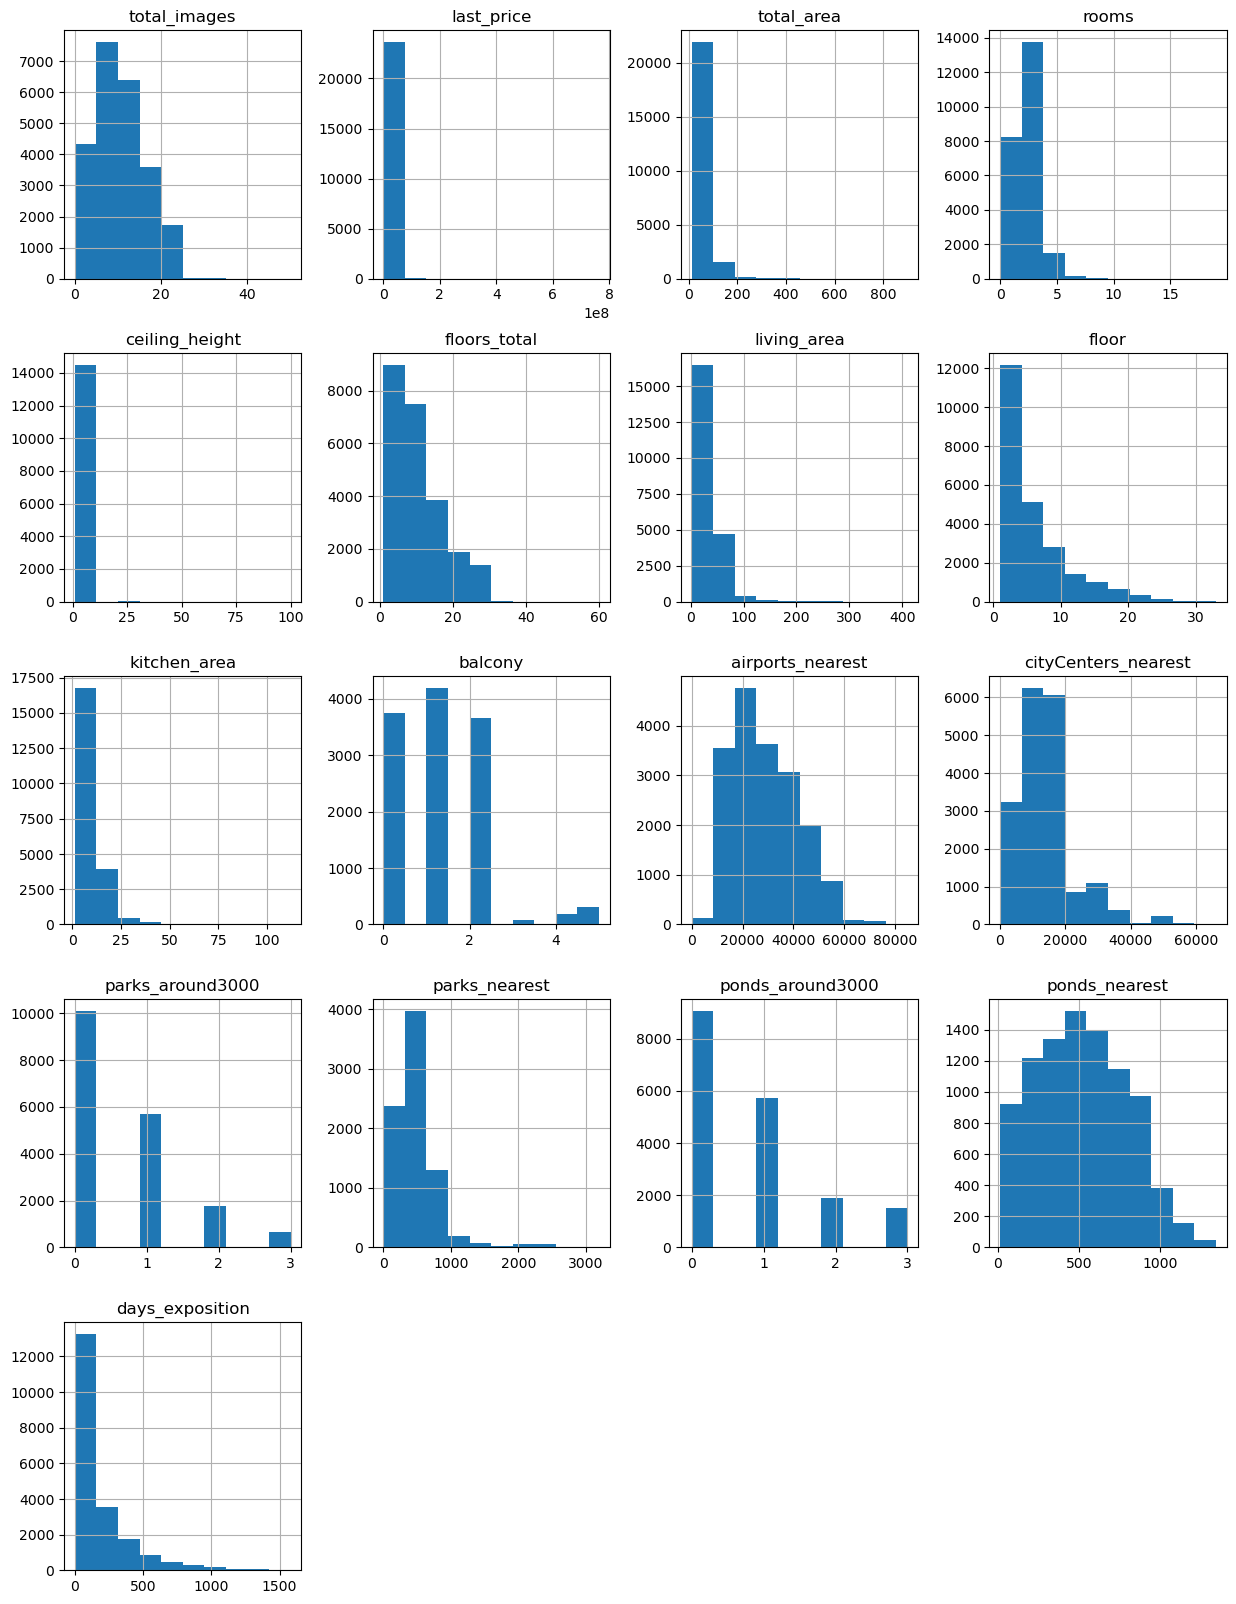

In [3]:
data.hist(figsize=(15, 20))
plt.show()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

 Вывод:
- в полученных данных 23699 строк
- в некоторых столбцах есть пропуски
- где-то нужно изменить тип данных
- некоторые гистограммы уже достаточно информативны (например, уже понятно, что мало квартир, в которых больше 2 балконов), а некоторые нужно редактировать, т.к по ним мало что понятно ('last_price')


## Предобработка данных

### Устранение пропусков

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Меньше всего пропусков в столбцах floors_total, locality_name. Можем удалить строки с этими пропусками

In [6]:
data = data.dropna(subset=['locality_name', 'floors_total'])

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area              1865
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             2222
balcony                 11475
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Заменим пропуски в столбце ceiling_height.Заполнять пропуски медианным значением по всей таблице кажется мне грубой мерой. Попробуем заполнить медианным значением по населённому пункту

In [84]:
import warnings 
warnings.filterwarnings("ignore")
data_ceiling = pd.read_csv('real_estate_data.csv', sep = '\t')
for locality in data_ceiling['locality_name'].unique():
    data_ceiling.loc[(data_ceiling['locality_name'] == locality) & (data_ceiling['ceiling_height'].isna()), 'ceiling_height'] = \
    data_ceiling.loc[data_ceiling['locality_name'] == locality, 'ceiling_height'].median()

In [85]:
data_ceiling['ceiling_height'].isna().sum()

156

Видим, что не заполнилось 156 пропусков, а среди новых значений теперь преобладают потолки 2,7 м, а до заполнения преобладали потолки 2,6 м. Заполнение пропусков в данном столбце приводит к искажению данных, поэтому не будем его трогать. Также поступим со столбцами parks_nearest и ponds_nearest ввиду большого количества пропусков в этих столбцах (14500 - 15500)

Пропуски в столбцах living_area и kitchen_area могут быть заполнены медианными значениям по категориям (возьмём количество комнат)

In [10]:
for rooms in data['rooms'].unique():
    data.loc[(data['rooms'] == rooms) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[data['rooms'] == rooms, 'living_area'].median()


In [11]:
data['living_area'].isna().sum()

0

Переходим к kitchen_area

In [12]:
for rooms in data['rooms'].unique():
    data.loc[(data['rooms'] == rooms) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[data['rooms'] == rooms, 'kitchen_area'].median()

In [13]:
data['kitchen_area'].isna().sum()

194

In [14]:
rooms0_amount = data.loc[data['rooms']==0, 'rooms'].count()
rooms0_amount

194

In [15]:
data_kitchen = data.loc[(data['rooms'] == 0) & (data['kitchen_area'].isna())]                                             
data_kitchen

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,NaN,24.0,15.50,2,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,NaN,14.0,17.00,1,NaN,...,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,NaN,17.0,24.75,4,NaN,...,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,NaN,26.0,24.30,19,NaN,...,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,NaN,10.0,18.00,7,NaN,...,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,NaN,25.0,18.00,16,NaN,...,NaN,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23442,0,2500000.0,27.70,2017-09-28T00:00:00,0,NaN,24.0,18.00,4,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,NaN,19.0,18.00,8,NaN,...,NaN,NaN,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0
23592,10,1450000.0,29.00,2017-11-11T00:00:00,0,NaN,9.0,18.00,8,NaN,...,NaN,2.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0


Видим, что для квартир, в которых 0 комнат, не указано ни одно значение площади кухни. Можно категоризовать данные по total_area и заполнить оставшиеся пропуски медианными значениями по этим категориям

In [16]:
def categorize_total_area(total_area):
    if total_area < 26:
        return 'E'
    if (total_area >= 26) and (total_area <= 50):
        return 'D'
    if (total_area >= 51) and (total_area <= 75):
        return 'C'
    if (total_area >= 76) and (total_area <= 100):
        return 'B'
    if total_area >= 100:
        return 'A'


In [17]:
data['total_area_category'] = data['total_area'].apply(categorize_total_area)

Находим и подставляем медианные значения

In [18]:
for category in data['total_area_category'].unique():
    data.loc[(data['total_area_category'] == category) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[data['total_area_category'] == category, 'kitchen_area'].median()

In [19]:
data['kitchen_area'].isna().sum()

0

Теперь пропуски в kitchen_area заполнены. Перейдём к столбцу balcony. Скорее всего пропуски обозначают отсутствие балконов, заполним их нулями. 

In [20]:
data['balcony'] = data['balcony'].fillna(0)

In [21]:
data['balcony'].isna().sum()

0

Под пропусками в столбце is_apartment наверняка предполагаются 0, то есть не являются апартаментами

In [22]:
data['is_apartment'] = data['is_apartment'].fillna(0)

In [23]:
data['is_apartment'].isna().sum()

0

Замечаем, что количество пропусков в ponds_around3000 и parks_around3000 одинаково. Проверим в одних и тех же строках пропуски

In [24]:
data_3000 = data.loc[(data['ponds_around3000'].isna()) & (data['parks_around3000'].isna())]
data_3000

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,0,...,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,D
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,0,...,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,D
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,0,...,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0,C
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,0,...,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0,C
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,17.60,2,0,...,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,0,...,0.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,0,...,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0,D
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,0,...,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,C
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,0,...,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C


Да, пропуски связаны, значит причина их возникновения - какая-то техническая ошибка при выгрузке данных. Вряд ли они обусловлены человеческим фактором. Теперь попробуем заполнить их медианным значением по населённому пункту

In [25]:
for locality in data['locality_name'].unique():
    data.loc[(data['locality_name'] == locality) & (data['ponds_around3000'].isna()), 'ponds_around3000'] = \
    data.loc[data['locality_name'] == locality, 'ponds_around3000'].median()

In [26]:
data_ponds = data.loc[data['ponds_around3000'].isna()]
data_ponds

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,0,...,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,D
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,0,...,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,D
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,0,...,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0,C
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,0,...,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0,C
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,17.60,2,0,...,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,0,...,0.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,0,...,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0,D
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,0,...,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,C
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,0,...,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C


Видим, что 5432 пропуска всё равно остаётся. Предполагаю, что это квартиры в различных посёлках, для которых расстояния до водоёмов не указывались ни разу. Перейдём к столбцу parks_around3000

In [27]:
for locality in data['locality_name'].unique():
    data.loc[(data['locality_name'] == locality) & (data['parks_around3000'].isna()), 'parks_around3000'] = \
    data.loc[data['locality_name'] == locality, 'parks_around3000'].median()

In [28]:
data['parks_around3000'].isna().sum()

5432

Также осталось 5432 пропуска. Т.к пропуски были в одних и тех же строках, такой результат ожидаем. Займёмся пропусками в airports_nearest и cityCenters_nearest. Воспользуемся той же логикой и будем подставлять медианные значения по населённому пункту

In [29]:
for locality in data['locality_name'].unique():
    data.loc[(data['locality_name'] == locality) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[data['locality_name'] == locality, 'airports_nearest'].median()

In [30]:
data['airports_nearest'].isna().sum()

5432

In [31]:
for locality in data['locality_name'].unique():
    data.loc[(data['locality_name'] == locality) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[data['locality_name'] == locality, 'cityCenters_nearest'].median()

In [32]:
data['cityCenters_nearest'].isna().sum()

5432

Опять 5432 пропуска остаётся. Посмотрим связаны ли пропуски в 4 столбцах

In [33]:
data_3000 = data.loc[(data['ponds_around3000'].isna()) & (data['parks_around3000'].isna()) & (data['airports_nearest'].isna()) & (data['cityCenters_nearest'].isna())]
data_3000

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,0,...,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,D
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,0,...,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,D
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,0,...,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0,C
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,0,...,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0,C
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,17.60,2,0,...,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,0,...,0.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,0,...,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0,D
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,0,...,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,C
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,0,...,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C


Да, в 5432 строчках не указаны расстояния до аэропортов, парков, центров и водоёмов. Видимо, техническая ошибка при выгрузке данных. Заполнить эти пропуски нечем и удалять такое количество строк нецелесообразно


Пропуски в столбце days_exposition могут означать, что объявление ещё не снято. Заполнять их не будем.

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        14481 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [35]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5432
cityCenters_nearest      5432
parks_around3000         5432
parks_nearest           15535
ponds_around3000         5432
ponds_nearest           14529
days_exposition          3171
total_area_category       300
dtype: int64

### Преобразование типов данных    
Приступим к рассмотрению типов данных. Следует изменить тип данных в столбцах is_apartment(bool, т.к единица означает, что квартира является апартаментами, а 0 - нет), first_day_exposition(datetime, т.к это дата) floors_total(int, т.к этажей может быть только целое количество), balcony(int, балконов также бывает целое количество), parks_around3000(int, т.к означает количество парков в определённом радиусе, оно тоже должно быть целым), ponds_around3000(int, такая же логика как и в parks_around3000), days_exposition(int, т.к в этом столбце указывается целое количество дней). Но в столбцах parks_around3000(int), ponds_around3000(int), days_exposition(int) изменить тип данных не получится, т.к там остались NaN.

In [36]:
data['is_apartment'] = data['is_apartment'].astype('bool')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int32')
data['balcony'] = data['balcony'].astype('int32')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

### Поиск неявных дубликатов

In [38]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [39]:
len(data['locality_name'].unique())

364

In [40]:
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')                                                    

In [41]:
len(data['locality_name'].unique())

323

### Поиск аномалий
    
  Построим диаграммы размаха и удалим (или обработаем) выбросы  

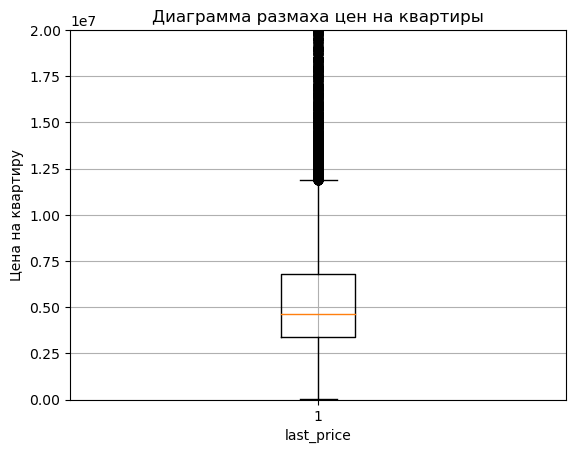

In [42]:
#начнём с last_price

plt.boxplot(x=data['last_price'])
plt.ylim(0, 20000000)
plt.title('Диаграмма размаха цен на квартиры')
plt.ylabel('Цена на квартиру')
plt.xlabel('last_price')
plt.grid(True)
plt.show()

Вывод из диаграммы размаха: окончательные цены на квартиры в основном лежат в диапазоне от 3 до 6 миллионов. Медиана находится около 4,5 миллионов

In [43]:
data.query('last_price > 20000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,45.00,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,A
42,13,22000000.0,161.8,2015-07-08,4,2.80,4,80.90,2,False,...,5,Петергоф,35416.0,30605.0,2.0,47.0,1.0,907.0,987.0,A
51,7,45000000.0,161.0,2017-10-17,3,3.20,8,38.00,4,False,...,0,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0,A
121,20,33000000.0,180.0,2017-02-17,3,2.90,9,86.00,8,False,...,4,Санкт-Петербург,25689.0,4264.0,1.0,633.0,0.0,NaN,144.0,A
147,10,27700000.0,179.6,2017-07-06,5,2.85,25,97.20,25,False,...,2,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,75.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23446,19,27000000.0,110.0,2016-03-11,3,NaN,7,63.00,5,False,...,1,Санкт-Петербург,26819.0,5026.0,1.0,657.0,1.0,678.0,200.0,A
23491,20,21800000.0,250.0,2017-09-16,3,NaN,12,104.00,7,False,...,0,Санкт-Петербург,43558.0,13138.0,0.0,NaN,0.0,NaN,49.0,A
23516,3,22529250.0,139.5,2018-07-04,4,3.30,16,82.55,9,False,...,0,Санкт-Петербург,37434.0,8460.0,1.0,441.0,2.0,427.0,266.0,A
23574,14,64990000.0,139.0,2015-11-24,3,3.00,8,3.00,8,False,...,1,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0,A


Видим 704 выбивающихся значения, их можно удалить

In [44]:
data = data.loc[data['last_price'] < 20000000]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22845 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22845 non-null  int64         
 1   last_price            22845 non-null  float64       
 2   total_area            22845 non-null  float64       
 3   first_day_exposition  22845 non-null  datetime64[ns]
 4   rooms                 22845 non-null  int64         
 5   ceiling_height        13984 non-null  float64       
 6   floors_total          22845 non-null  int32         
 7   living_area           22845 non-null  float64       
 8   floor                 22845 non-null  int64         
 9   is_apartment          22845 non-null  bool          
 10  studio                22845 non-null  bool          
 11  open_plan             22845 non-null  bool          
 12  kitchen_area          22845 non-null  float64       
 13  balcony         

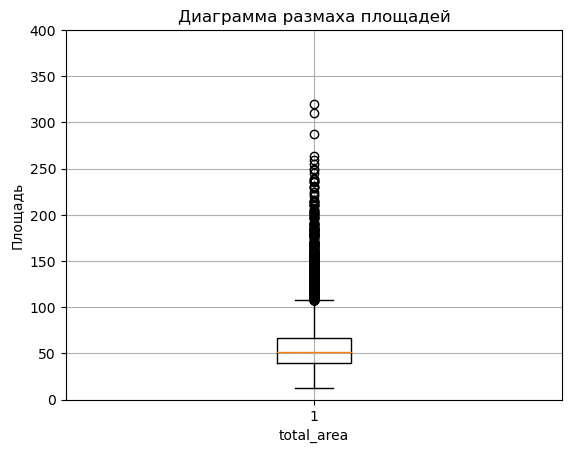

In [45]:
#total_area
plt.boxplot(x=data['total_area'])
plt.ylim(0, 400)
plt.title('Диаграмма размаха площадей')
plt.ylabel('Площадь')
plt.xlabel('total_area')
plt.grid(True)
plt.show()

Вывод из диаграммы размаха: общая площадь квартир 40-60 м2. Медиана 50 м2

In [46]:
data = data.loc[data['total_area'] < 200]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22802 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22802 non-null  int64         
 1   last_price            22802 non-null  float64       
 2   total_area            22802 non-null  float64       
 3   first_day_exposition  22802 non-null  datetime64[ns]
 4   rooms                 22802 non-null  int64         
 5   ceiling_height        13960 non-null  float64       
 6   floors_total          22802 non-null  int32         
 7   living_area           22802 non-null  float64       
 8   floor                 22802 non-null  int64         
 9   is_apartment          22802 non-null  bool          
 10  studio                22802 non-null  bool          
 11  open_plan             22802 non-null  bool          
 12  kitchen_area          22802 non-null  float64       
 13  balcony         

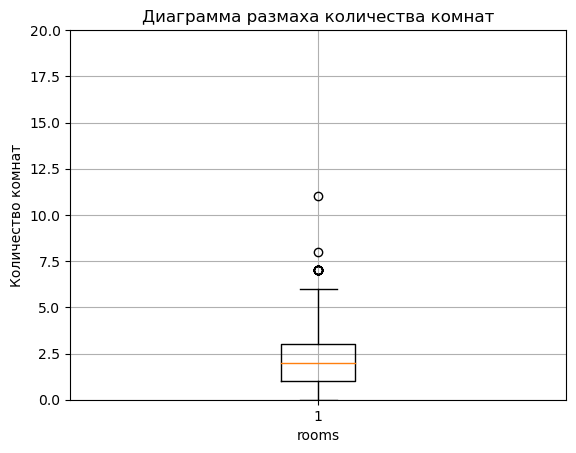

In [47]:
#rooms
plt.boxplot(x=data['rooms'])
plt.ylim(0, 20)
plt.title('Диаграмма размаха количества комнат')
plt.ylabel('Количество комнат')
plt.xlabel('rooms')
plt.grid(True)
plt.show()

Вывод из диаграммы размаха: число комнат от 1 до 3. Медиана = 2

In [48]:
data = data.loc[data['rooms'] < 7]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22787 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22787 non-null  int64         
 1   last_price            22787 non-null  float64       
 2   total_area            22787 non-null  float64       
 3   first_day_exposition  22787 non-null  datetime64[ns]
 4   rooms                 22787 non-null  int64         
 5   ceiling_height        13951 non-null  float64       
 6   floors_total          22787 non-null  int32         
 7   living_area           22787 non-null  float64       
 8   floor                 22787 non-null  int64         
 9   is_apartment          22787 non-null  bool          
 10  studio                22787 non-null  bool          
 11  open_plan             22787 non-null  bool          
 12  kitchen_area          22787 non-null  float64       
 13  balcony         

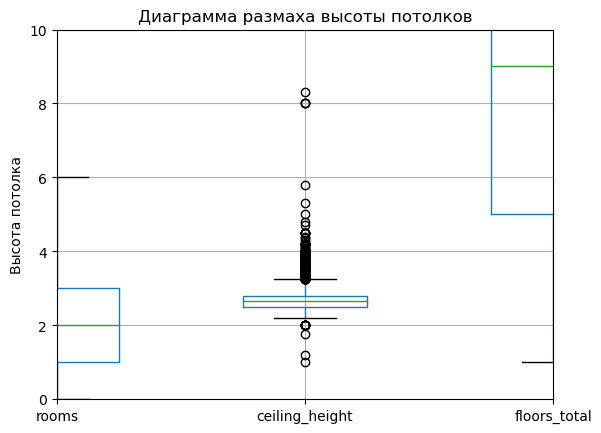

In [49]:
#ceiling_height
data.boxplot()
plt.ylim(0, 10)
plt.xlim(4, 6)
plt.title('Диаграмма размаха высоты потолков')
plt.ylabel('Высота потолка')
plt.show()

Высота потолка > 5м могла возникнуть из-за неправильного ввода информации. Разделим значения > 10м на 10

In [50]:
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10,'ceiling_height']/10


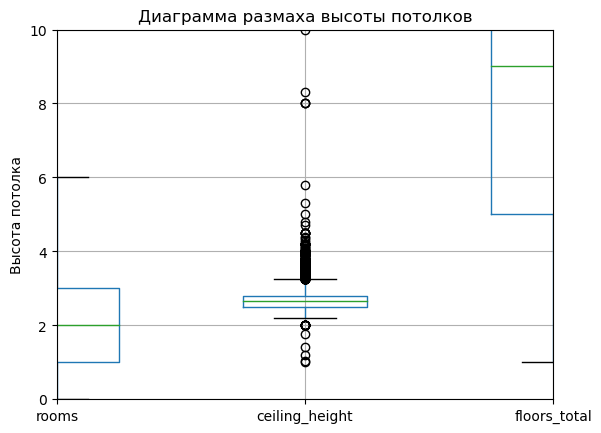

In [51]:
#ceiling_height
data.boxplot()
plt.ylim(0, 10)
plt.xlim(4, 6)
plt.title('Диаграмма размаха высоты потолков')
plt.ylabel('Высота потолка')
plt.show()

Вывод из диаграммы размаха: высота потолков в большинстве случаев 2,5-2,7 метра

In [52]:
data = data.drop(data.loc[data['ceiling_height'] <2].index)
data = data.drop(data.loc[data['ceiling_height'] >4].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22747 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22747 non-null  int64         
 1   last_price            22747 non-null  float64       
 2   total_area            22747 non-null  float64       
 3   first_day_exposition  22747 non-null  datetime64[ns]
 4   rooms                 22747 non-null  int64         
 5   ceiling_height        13911 non-null  float64       
 6   floors_total          22747 non-null  int32         
 7   living_area           22747 non-null  float64       
 8   floor                 22747 non-null  int64         
 9   is_apartment          22747 non-null  bool          
 10  studio                22747 non-null  bool          
 11  open_plan             22747 non-null  bool          
 12  kitchen_area          22747 non-null  float64       
 13  balcony         

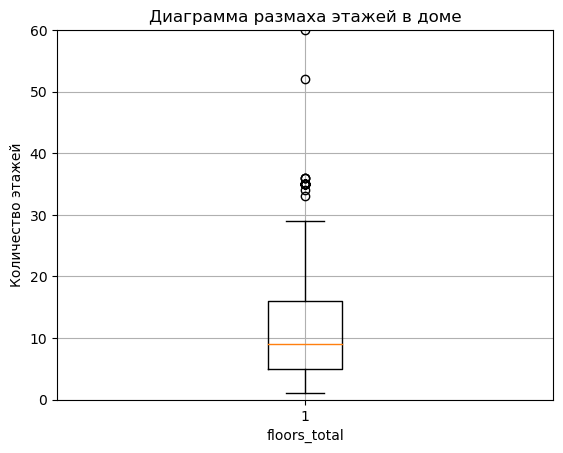

In [53]:
#floors_total
plt.boxplot(x=data['floors_total'])
plt.ylim(0, 60)
plt.title('Диаграмма размаха этажей в доме')
plt.ylabel('Количество этажей')
plt.xlabel('floors_total')
plt.grid(True)
plt.show()

Вывод из диаграммы размаха:количество этажей в доме 5-16. Медиана = 9

In [54]:
data = data.loc[data['floors_total'] <30]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22716 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22716 non-null  int64         
 1   last_price            22716 non-null  float64       
 2   total_area            22716 non-null  float64       
 3   first_day_exposition  22716 non-null  datetime64[ns]
 4   rooms                 22716 non-null  int64         
 5   ceiling_height        13898 non-null  float64       
 6   floors_total          22716 non-null  int32         
 7   living_area           22716 non-null  float64       
 8   floor                 22716 non-null  int64         
 9   is_apartment          22716 non-null  bool          
 10  studio                22716 non-null  bool          
 11  open_plan             22716 non-null  bool          
 12  kitchen_area          22716 non-null  float64       
 13  balcony         

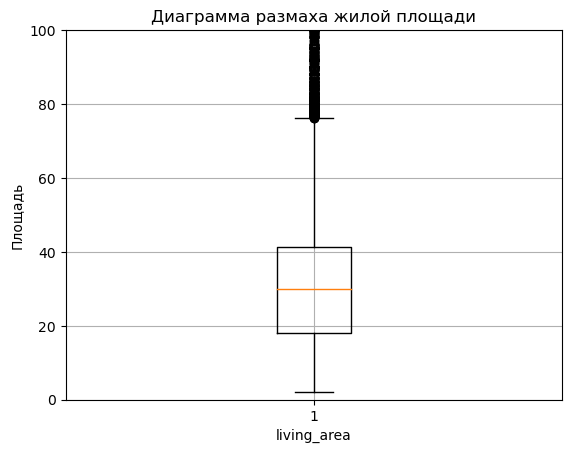

In [55]:
#living_area
plt.boxplot(x=data['living_area'])
plt.ylim(0, 100)
plt.title('Диаграмма размаха жилой площади')
plt.ylabel('Площадь')
plt.xlabel('living_area')
plt.grid(True)
plt.show()

Вывод из диаграммы размаха: жилая площадь в среднем 20-40 м2. Медиана = 30м2

In [56]:
data = data.loc[data['living_area'] < 90]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22523 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22523 non-null  int64         
 1   last_price            22523 non-null  float64       
 2   total_area            22523 non-null  float64       
 3   first_day_exposition  22523 non-null  datetime64[ns]
 4   rooms                 22523 non-null  int64         
 5   ceiling_height        13763 non-null  float64       
 6   floors_total          22523 non-null  int32         
 7   living_area           22523 non-null  float64       
 8   floor                 22523 non-null  int64         
 9   is_apartment          22523 non-null  bool          
 10  studio                22523 non-null  bool          
 11  open_plan             22523 non-null  bool          
 12  kitchen_area          22523 non-null  float64       
 13  balcony         

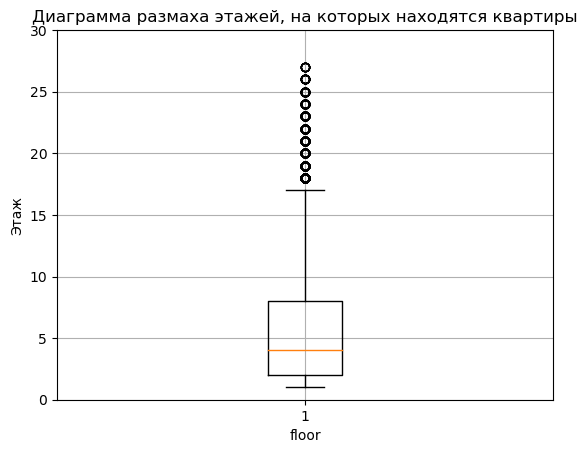

In [57]:
#floor
plt.boxplot(x=data['floor'])
plt.ylim(0, 30)
plt.title('Диаграмма размаха этажей, на которых находятся квартиры')
plt.ylabel('Этаж')
plt.xlabel('floor')
plt.grid(True)
plt.show()

Вывод из диаграммы размаха:этаж квартир в основном 2-8. Медиана = 4

In [58]:
data = data.loc[data['floor'] < 25]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22450 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22450 non-null  int64         
 1   last_price            22450 non-null  float64       
 2   total_area            22450 non-null  float64       
 3   first_day_exposition  22450 non-null  datetime64[ns]
 4   rooms                 22450 non-null  int64         
 5   ceiling_height        13729 non-null  float64       
 6   floors_total          22450 non-null  int32         
 7   living_area           22450 non-null  float64       
 8   floor                 22450 non-null  int64         
 9   is_apartment          22450 non-null  bool          
 10  studio                22450 non-null  bool          
 11  open_plan             22450 non-null  bool          
 12  kitchen_area          22450 non-null  float64       
 13  balcony         

В столбцах с булевыми значениями не может быть аномалий

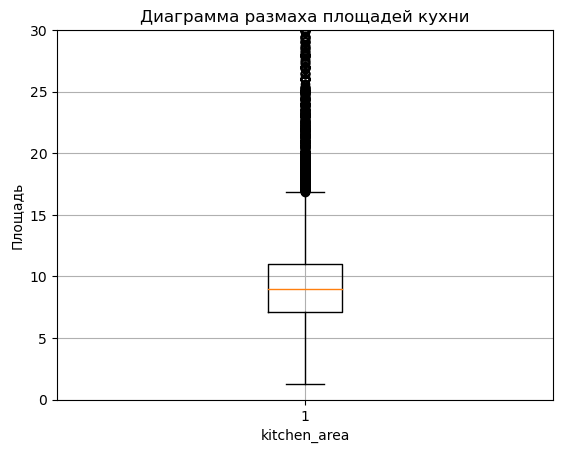

In [59]:
#kitchen_area
plt.boxplot(x=data['kitchen_area'])
plt.ylim(0, 30)
plt.title('Диаграмма размаха площадей кухни')
plt.ylabel('Площадь')
plt.xlabel('kitchen_area')
plt.grid(True)
plt.show()

Вывод из диаграммы размаха: площадь кухни у большинства квартир 7-11 м2. Медиана = 9 м2

In [60]:
data = data.loc[data['kitchen_area'] < 30]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22264 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22264 non-null  int64         
 1   last_price            22264 non-null  float64       
 2   total_area            22264 non-null  float64       
 3   first_day_exposition  22264 non-null  datetime64[ns]
 4   rooms                 22264 non-null  int64         
 5   ceiling_height        13595 non-null  float64       
 6   floors_total          22264 non-null  int32         
 7   living_area           22264 non-null  float64       
 8   floor                 22264 non-null  int64         
 9   is_apartment          22264 non-null  bool          
 10  studio                22264 non-null  bool          
 11  open_plan             22264 non-null  bool          
 12  kitchen_area          22264 non-null  float64       
 13  balcony         

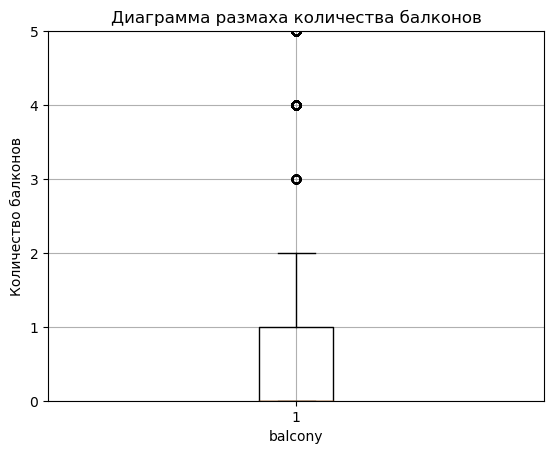

In [61]:
#balcony
plt.boxplot(x=data['balcony'])
plt.ylim(0, 5)
plt.title('Диаграмма размаха количества балконов')
plt.ylabel('Количество балконов')
plt.xlabel('balcony')
plt.grid(True)
plt.show()

Вывод из диаграммы размаха:балконов чаще всего 0-1

In [62]:
data = data.loc[data['balcony'] <= 3]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21827 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21827 non-null  int64         
 1   last_price            21827 non-null  float64       
 2   total_area            21827 non-null  float64       
 3   first_day_exposition  21827 non-null  datetime64[ns]
 4   rooms                 21827 non-null  int64         
 5   ceiling_height        13263 non-null  float64       
 6   floors_total          21827 non-null  int32         
 7   living_area           21827 non-null  float64       
 8   floor                 21827 non-null  int64         
 9   is_apartment          21827 non-null  bool          
 10  studio                21827 non-null  bool          
 11  open_plan             21827 non-null  bool          
 12  kitchen_area          21827 non-null  float64       
 13  balcony         

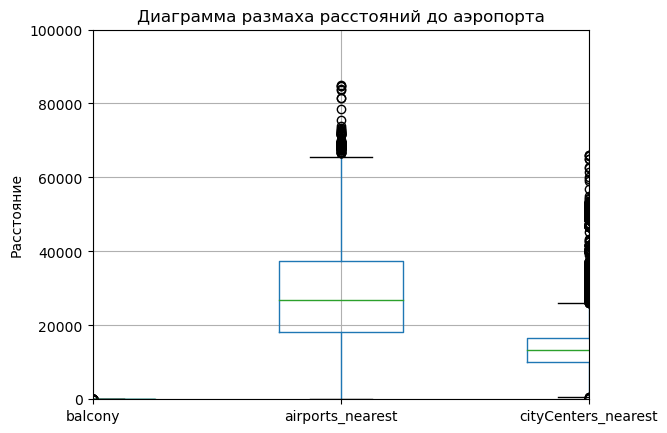

In [63]:
#airports_nearest
data.boxplot()
plt.ylim(0,100000)
plt.xlim(13, 15)
plt.title('Диаграмма размаха расстояний до аэропорта')
plt.ylabel('Расстояние')
plt.show()

Вывод из диаграммы размаха: ближайшие аэропорты расположены в 19-39 км. Медиана = 30 км

In [64]:
data = data.drop(data.loc[data['airports_nearest'] > 75000].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21818 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21818 non-null  int64         
 1   last_price            21818 non-null  float64       
 2   total_area            21818 non-null  float64       
 3   first_day_exposition  21818 non-null  datetime64[ns]
 4   rooms                 21818 non-null  int64         
 5   ceiling_height        13255 non-null  float64       
 6   floors_total          21818 non-null  int32         
 7   living_area           21818 non-null  float64       
 8   floor                 21818 non-null  int64         
 9   is_apartment          21818 non-null  bool          
 10  studio                21818 non-null  bool          
 11  open_plan             21818 non-null  bool          
 12  kitchen_area          21818 non-null  float64       
 13  balcony         

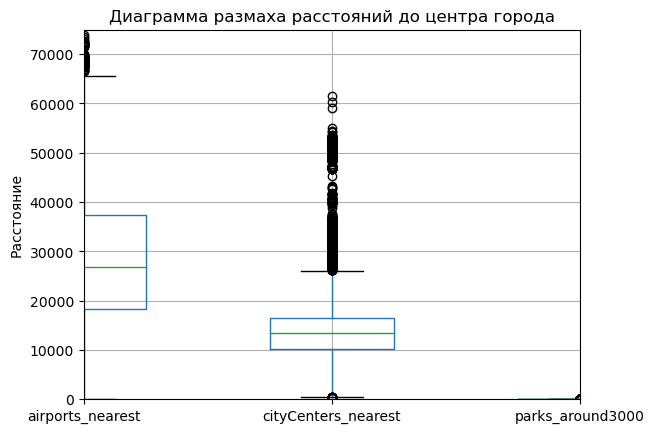

In [65]:
#cityCenters_nearest
data.boxplot()
plt.ylim(0,75000)
plt.xlim(14, 16)
plt.title('Диаграмма размаха расстояний до центра города')
plt.ylabel('Расстояние')
plt.show()

Вывод из диаграммы размаха:центры городов обычно назодятся в 10-16 км. Медиана = 14 км

In [66]:
data = data.drop(data.loc[data['cityCenters_nearest'] > 50000].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21646 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21646 non-null  int64         
 1   last_price            21646 non-null  float64       
 2   total_area            21646 non-null  float64       
 3   first_day_exposition  21646 non-null  datetime64[ns]
 4   rooms                 21646 non-null  int64         
 5   ceiling_height        13133 non-null  float64       
 6   floors_total          21646 non-null  int32         
 7   living_area           21646 non-null  float64       
 8   floor                 21646 non-null  int64         
 9   is_apartment          21646 non-null  bool          
 10  studio                21646 non-null  bool          
 11  open_plan             21646 non-null  bool          
 12  kitchen_area          21646 non-null  float64       
 13  balcony         

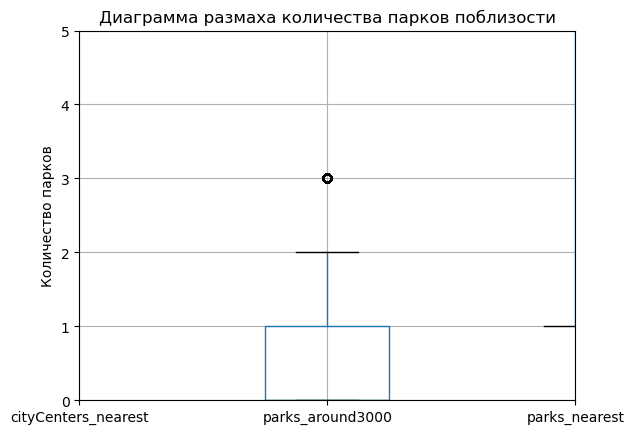

In [67]:
#parks_around3000
data.boxplot()
plt.ylim(0,5)
plt.xlim(15, 17)
plt.title('Диаграмма размаха количества парков поблизости')
plt.ylabel('Количество парков')
plt.show()

Вывод из диаграммы размаха: у большинства квартир в радиусе 3 км находится 0-1 парк

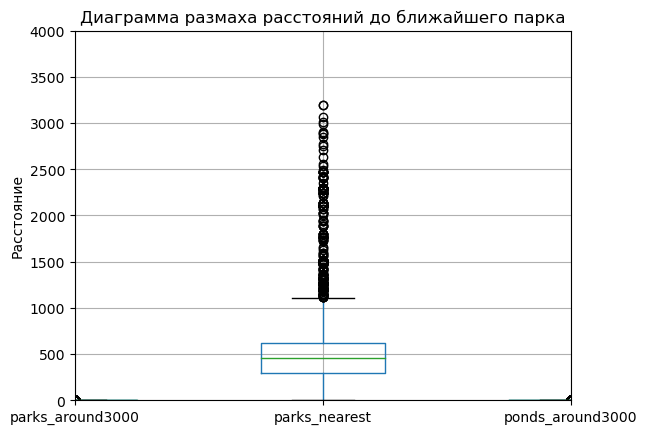

In [68]:
#parks_nearest
data.boxplot()
plt.ylim(0,4000)
plt.xlim(16, 18)
plt.title('Диаграмма размаха расстояний до ближайшего парка')
plt.ylabel('Расстояние')
plt.show()

Вывод из диаграммы размаха: ближайшие парки чаще всего в 400-600 м. Медиана = 500м

In [69]:
data = data.drop(data.loc[data['parks_nearest'] >= 2500].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21631 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21631 non-null  int64         
 1   last_price            21631 non-null  float64       
 2   total_area            21631 non-null  float64       
 3   first_day_exposition  21631 non-null  datetime64[ns]
 4   rooms                 21631 non-null  int64         
 5   ceiling_height        13123 non-null  float64       
 6   floors_total          21631 non-null  int32         
 7   living_area           21631 non-null  float64       
 8   floor                 21631 non-null  int64         
 9   is_apartment          21631 non-null  bool          
 10  studio                21631 non-null  bool          
 11  open_plan             21631 non-null  bool          
 12  kitchen_area          21631 non-null  float64       
 13  balcony         

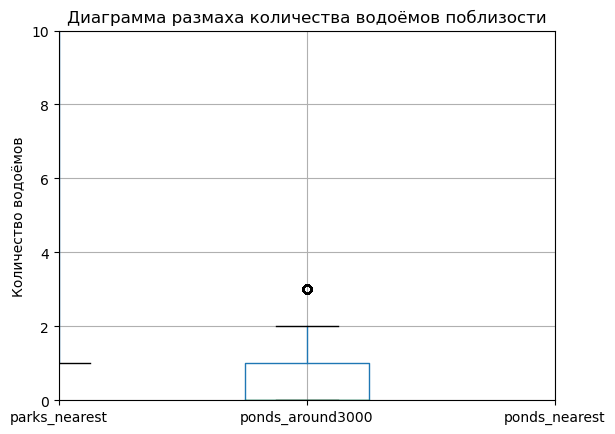

In [70]:
#ponds_around3000
data.boxplot()
plt.ylim(0,10)
plt.xlim(17, 19)
plt.title('Диаграмма размаха количества водоёмов поблизости')
plt.ylabel('Количество водоёмов')
plt.show()

Вывод из диаграммы размаха: чаще всего в радиусе 3км 0-1 водоём.

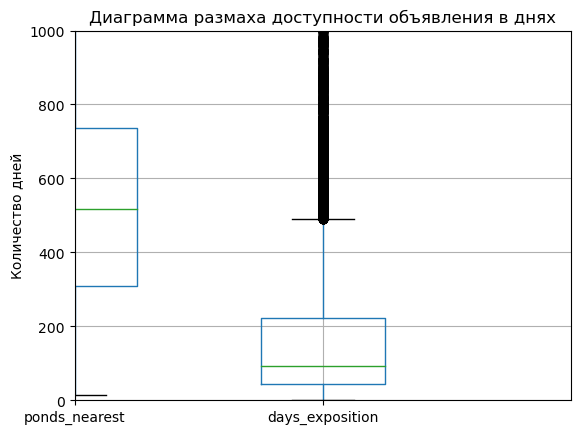

In [71]:
#days_exposition
data.boxplot()
plt.ylim(0,1000)
plt.xlim(19, 21)
plt.title('Диаграмма размаха доступности объявления в днях')
plt.ylabel('Количество дней')
plt.show()

Вывод из диаграммы размаха: чаще всего объявление доступно 40-200 дней. Медиана = 90

In [72]:
data.loc[data['days_exposition'] > 500, 'days_exposition'].count()

1515

Выбивающихся значений в этом столбце очень много, не будем их удалять. Осталось навести порядок в индексах

In [73]:
data = data.reset_index(drop=True)
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
0,20,13000000.0,108.00,2019-03-07,3,2.7,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,A
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.6,1,False,...,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,D
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,C
3,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.4,5,False,...,0,поселок городского типа Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,D
4,6,3700000.0,37.30,2017-11-02,1,NaN,26,10.6,6,False,...,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21626,9,9700000.0,133.81,2017-03-21,3,3.7,5,73.3,3,False,...,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,A
21627,14,3100000.0,59.00,2018-01-15,3,NaN,5,38.0,4,False,...,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,C
21628,18,2500000.0,56.70,2018-02-11,2,NaN,3,29.7,1,False,...,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
21629,13,11475000.0,76.75,2017-03-28,2,3.0,17,30.5,12,False,...,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,B


### Добавление новых столбцов

In [74]:
data['price_per_meter'] = data['last_price']/data['total_area']

In [75]:
data['first_day_weekday'] = data['first_day_exposition'].dt.weekday

In [76]:
data['first_day_month'] = data['first_day_exposition'].dt.month

In [77]:
data['first_day_year'] = data['first_day_exposition'].dt.year

In [78]:
def categorize_floor(data):
    
    if data['floor'] == 1:
        return 'первый'
    if data['floor'] == data['floors_total']:
        return 'последний'
    else:
        return 'другой'
    

In [79]:
data['floor_category'] =data.apply(categorize_floor, axis=1)

In [80]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round()

In [81]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,total_area_category,price_per_meter,first_day_weekday,first_day_month,first_day_year,floor_category,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.7,16,51.0,8,False,...,2.0,755.0,NaN,A,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,0.0,NaN,81.0,D,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,2.0,574.0,558.0,C,92785.714286,3,8,2015,другой,14.0
3,10,2890000.0,30.4,2018-09-10,1,NaN,12,14.4,5,False,...,NaN,NaN,55.0,D,95065.789474,0,9,2018,другой,NaN
4,6,3700000.0,37.3,2017-11-02,1,NaN,26,10.6,6,False,...,0.0,NaN,155.0,D,99195.710456,3,11,2017,другой,19.0


## Исследовательский анализ данных

При поиске аномалий я уже построила диаграммы размаха для столбцов с числовыми значениями и сделала выводы о медиане значений, первом и третьем квартилях. Построим гистограммы и посмотрим, как соотносятся данные

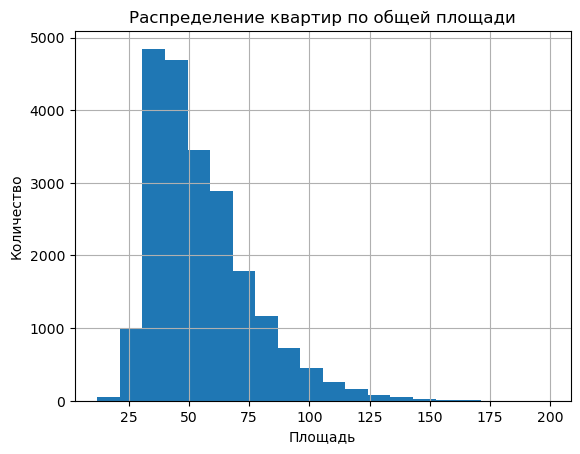

In [82]:
data['total_area'].plot(kind ='hist', bins=20, title='Распределение квартир по общей площади', grid=True)
plt.ylabel('Количество')
plt.xlabel('Площадь')
plt.show()

Вывод: больше всего квартир с общей площадью 40м2(больше 2500). Самые высокие пики наблюдаются для квартир с площадью 30-60 м2.

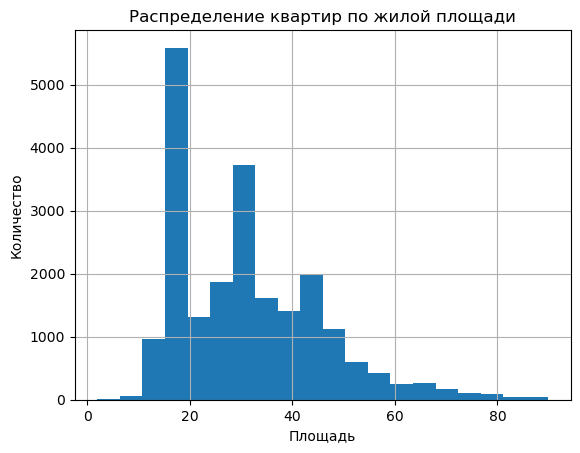

In [86]:
data['living_area'].plot(kind ='hist', bins=20, title='Распределение квартир по жилой площади', grid=True)
plt.ylabel('Количество')
plt.xlabel('Площадь')
plt.show()

Вывод: больше всего квартир с жилой площадью 20м2(больше 4000). Второй высокий пик  для квартир с площадью 30 м2.

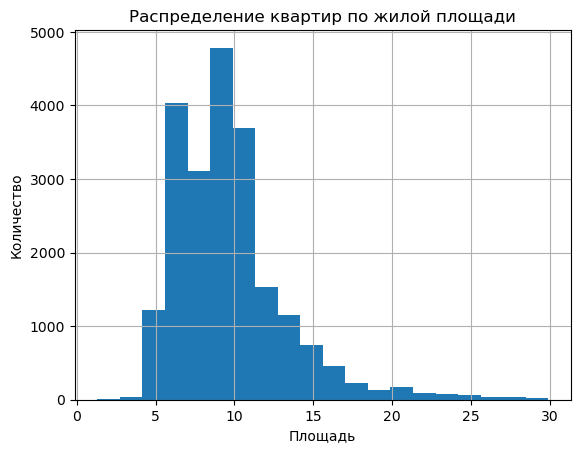

In [87]:
data['kitchen_area'].plot(kind ='hist', bins=20, title='Распределение квартир по жилой площади', grid=True)
plt.ylabel('Количество')
plt.xlabel('Площадь')
plt.show()

Вывод: больше всего квартир с площадью кухни 8м2(больше 3000). Самые высокие пики находятся на 6-10 м2

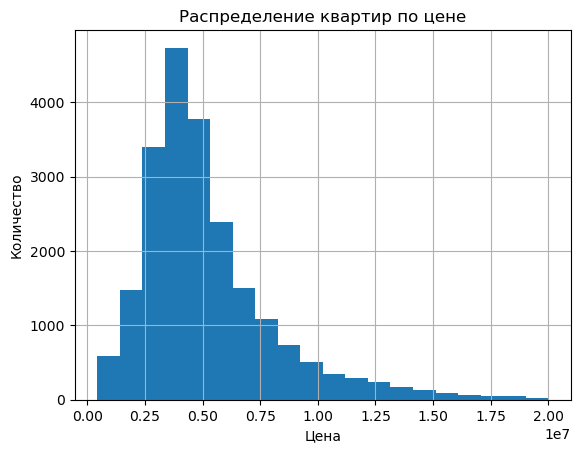

In [88]:
data['last_price'].plot(kind ='hist', bins=20, title='Распределение квартир по цене', grid=True)
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.show()

Вывод: больше всего квартир стоят 4 миллиона (больше 4000). Также много квартир за 2,5 и 5 миллионов

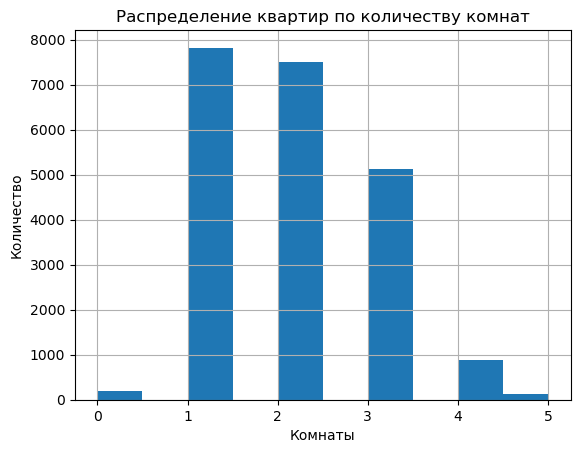

In [89]:
data['rooms'].plot(kind ='hist', title='Распределение квартир по количеству комнат', grid=True, range = (0,5))
plt.ylabel('Количество')
plt.xlabel('Комнаты')
plt.show()

Вывод: больше всего квартир однокомнатных, но 2,3-комнатных тоже много

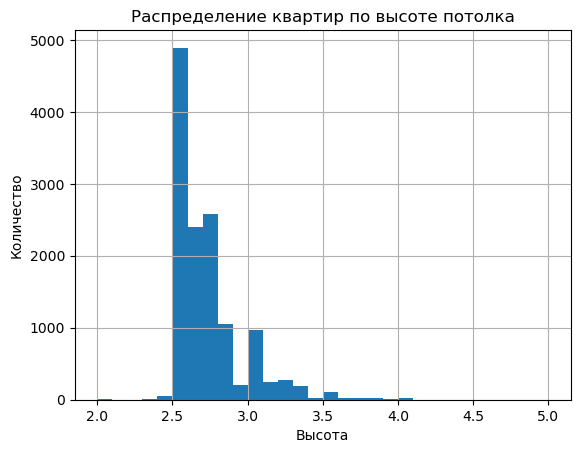

In [90]:
data['ceiling_height'].plot(kind ='hist', bins=30, title='Распределение квартир по высоте потолка', grid=True, range=(2,5))
plt.ylabel('Количество')
plt.xlabel('Высота')
plt.show()

Вывод: в большинстве квартир потолки 2,5 м (больше 4000). Также много квартир с потолками 2,6 и 2,7 м.

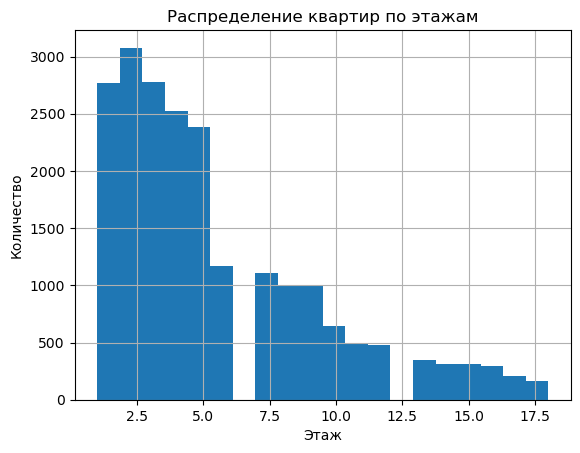

In [91]:
data['floor'].plot(kind ='hist', bins=20, title='Распределение квартир по этажам', grid=True, range=(1,18))
plt.ylabel('Количество')
plt.xlabel('Этаж')
plt.show()

Вывод: больше всего квартир на 2 этаже (больше 2500), чуть меньше квартир на 1 этаже (около 2400)

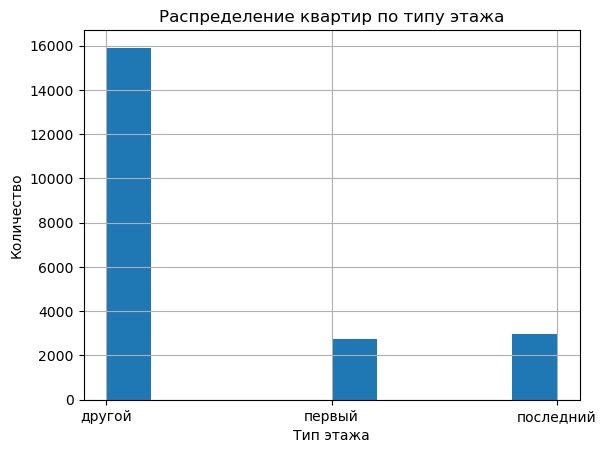

In [92]:
plt.hist(data=data, x='floor_category')
plt.title('Распределение квартир по типу этажа')
plt.ylabel('Количество')
plt.xlabel('Тип этажа')
plt.grid(True)
plt.show()

Вывод: большинство квартир находятся не на 1 и не на последнем этаже.

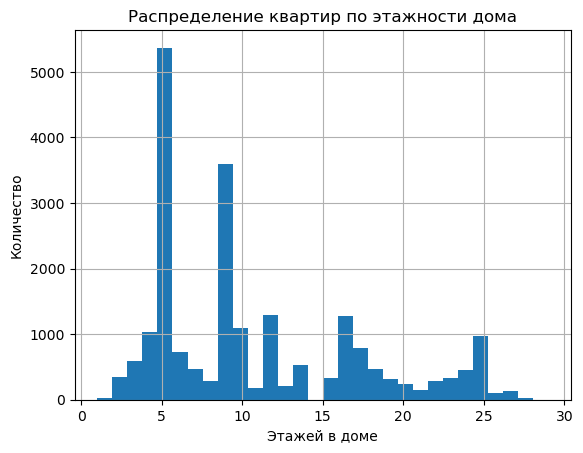

In [93]:
data['floors_total'].plot(kind ='hist', bins=30, title='Распределение квартир по этажности дома', grid=True)
plt.ylabel('Количество')
plt.xlabel('Этажей в доме')
plt.show()

Вывод: больше всего квартир находятся в пятиэтажных домах (больше 4000), на втором месте девятиэтажные (около 3000)

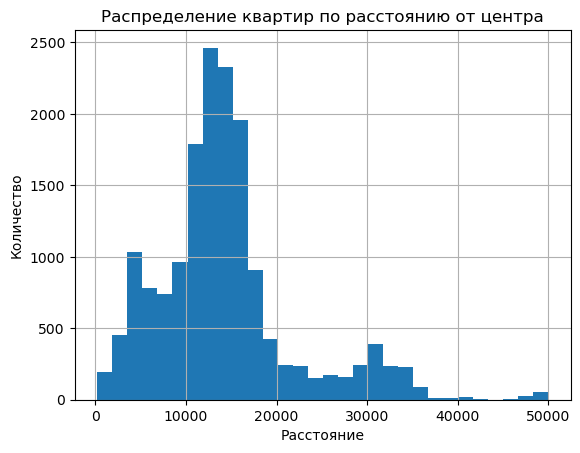

In [94]:
data['cityCenters_nearest'].plot(kind ='hist', bins=30, title='Распределение квартир по расстоянию от центра', grid=True)
plt.ylabel('Количество')
plt.xlabel('Расстояние')
plt.show()

Вывод: чаще всего центр города находится в 12000 м. В основном расстояние 11000-16000

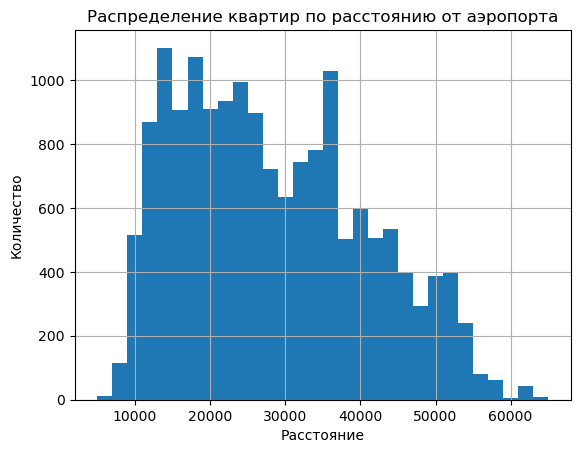

In [95]:
data['airports_nearest'].plot(kind ='hist', bins=30, title='Распределение квартир по расстоянию от аэропорта', grid=True, range =(5000, 65000))
plt.ylabel('Количество')
plt.xlabel('Расстояние')
plt.show()

Вывод: чаще всего аэропорт находится в 12000 м (в 1000 случаев). Для большинства квартир расстояние 11000-33000м

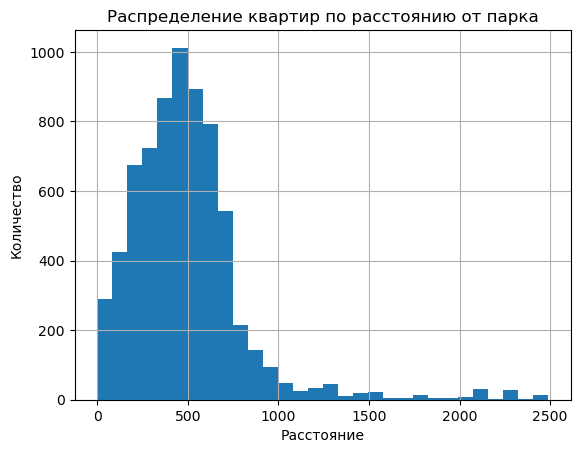

In [96]:
data['parks_nearest'].plot(kind ='hist', bins=30, title='Распределение квартир по расстоянию от парка', grid=True)
plt.ylabel('Количество')
plt.xlabel('Расстояние')
plt.show()

Вывод: больше чем у 500 квартир ближайший парк находится в 500 м. Чаще всего это расстояние 250-700м

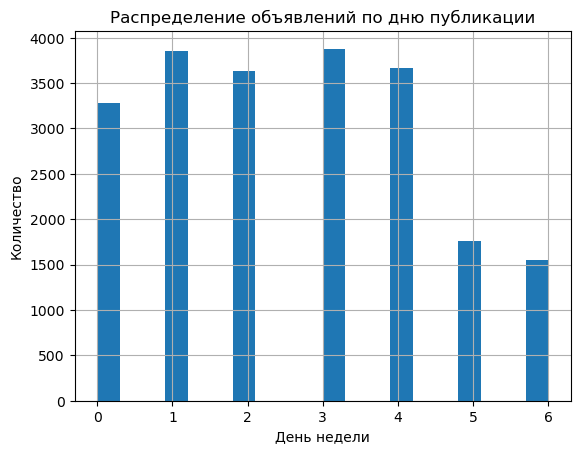

In [97]:
data['first_day_weekday'].plot(kind ='hist', bins=20, title='Распределение объявлений по дню публикации', grid=True)
plt.ylabel('Количество')
plt.xlabel('День недели')
plt.show()

Вывод: чаще всего объявления публикуют во вторник и четверг (больше 3000 в каждый из дней). Реже всего объявления публикуют в выходные

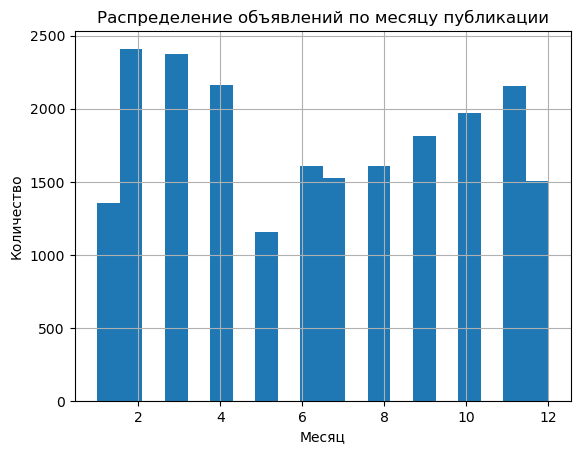

In [98]:
data['first_day_month'].plot(kind ='hist', bins=20, title='Распределение объявлений по месяцу публикации', grid=True)
plt.ylabel('Количество')
plt.xlabel('Месяц')
plt.show()

Вывод:чаще объявления публиковались в феврале и марте (около 2000 объявлений каждый месяц). Меньше всего объявлений было в мае (меньше 1000)

Общий вывод: данные, полученные с помощью гистограмм, хорошо согласутся с данными, полученными с помощью диаграмм размаха

### Изучение времени продажи квартиры
    

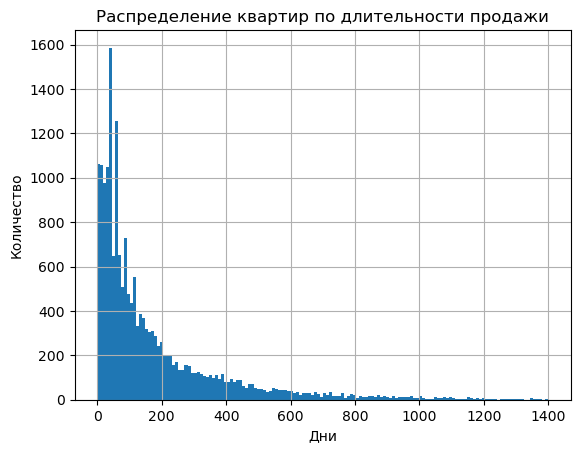

In [99]:
data['days_exposition'].plot(kind ='hist', bins=150, title='Распределение квартир по длительности продажи', grid=True, range=(0,1400))
plt.ylabel('Количество')
plt.xlabel('Дни')
plt.show()

In [413]:
data['days_exposition'].mean()

175.3131714028682

In [414]:
data['days_exposition'].median()

92.0

Вывод:больше 5000 квартир продались за первые 50 дней - это самые быстре продажи. С увеличением времени падает количество проданных квартир. Самые медленные продажи - 1300 дней, их немного, но они влияют на среднее значение времени продаж, поэтому медиана отличается от среднего почти в 2 раза.

### Изучение зависимости цены квартиры от различных факторов

In [415]:
data['total_area'].corr(data['last_price'])

0.7484128377809306

In [416]:
data_total_area = data.pivot_table(index = 'total_area', values='last_price', aggfunc='median')
data_total_area

,last_price
total_area,
12.00,2400000.0
13.00,1850000.0
13.20,1686000.0
14.00,1190000.0
15.00,1725000.0
...,...
170.00,15000000.0
182.84,16008000.0
185.00,4500000.0


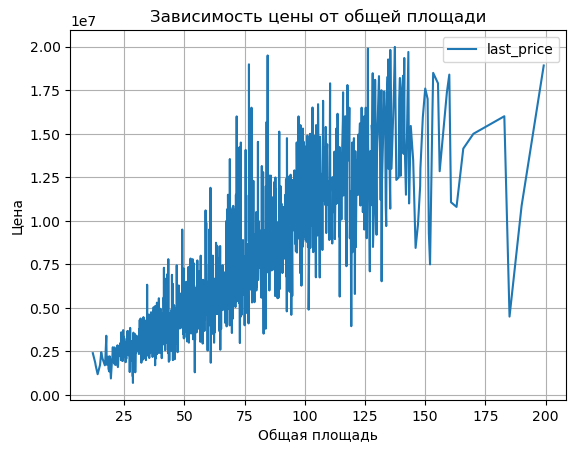

In [417]:
data_total_area.plot(title='Зависимость цены от общей площади',
                     grid=True)
plt.ylabel('Цена')
plt.xlabel('Общая площадь')
plt.show()

Вывод: прослеживается общая тенденция - с увеличением площади растёт и цена. Это подтверждает коэффициент корреляции Пирсона (0,7). Однако присутствует заметное количество выбросов. 
Вероятно, диаграмма рассеяния будет более информативна.


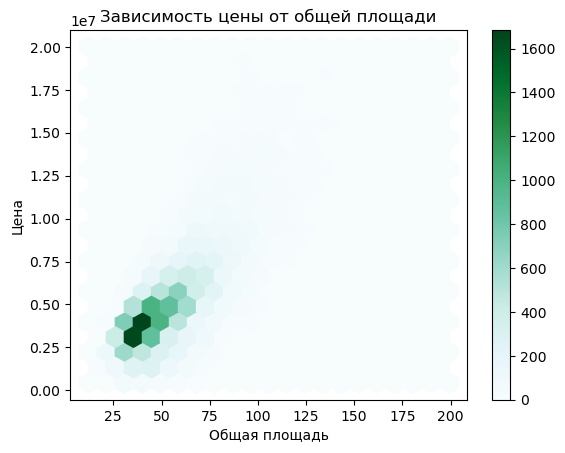

In [418]:
data.plot(x='total_area',
          y='last_price',
          kind='hexbin',
          gridsize=20,
          title='Зависимость цены от общей площади')
plt.ylabel('Цена')
plt.xlabel('Общая площадь')
plt.show()

Видим, что больше всего квартир площадью 30-50м2 стоимостью 2500000-5000000. Однако это не очень помогает выявить зависимость

In [419]:
data['living_area'].corr(data['last_price'])

0.6136614285902956

In [420]:
data_living_area = data.pivot_table(index = 'living_area', values='last_price', aggfunc='median')
data_living_area

,last_price
living_area,
2.0,4340000.0
3.0,4440000.0
5.0,2680000.0
5.4,6100000.0
6.0,3799000.0
...,...
89.3,15100000.0
89.4,16300000.0
89.5,10350000.0


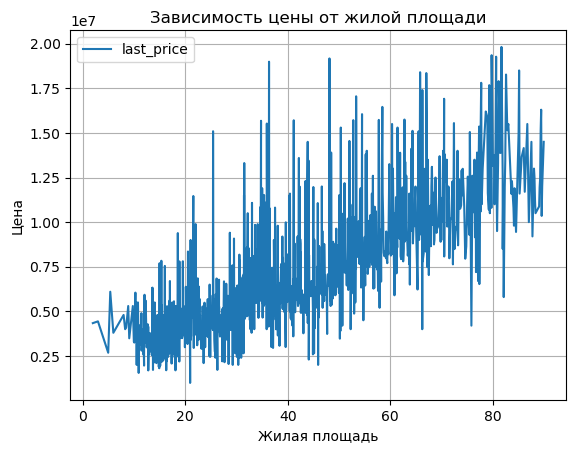

In [421]:
data_living_area.plot(title='Зависимость цены от жилой площади',
                      grid=True)
plt.ylabel('Цена')
plt.xlabel('Жилая площадь')
plt.show()

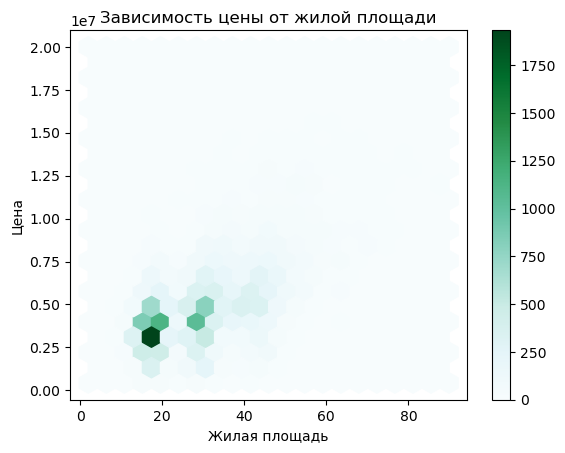

In [422]:
data.plot(x='living_area',
          y='last_price',
          kind='hexbin',
          gridsize=20,
          title='Зависимость цены от жилой площади')
plt.ylabel('Цена')
plt.xlabel('Жилая площадь')
plt.show()

Вывод: опять прослеживается рост цены с увеличением площади. Однако выбросов много, и судя по коэффициенту корреляции их больше, чем в предыдущем случае, а значит от жилой площади цена зависит меньше, чем от общей.

In [423]:
data['kitchen_area'].corr(data['last_price'])

0.5197200370289773

In [424]:
data_kitchen_area = data.pivot_table(index = 'kitchen_area', values='last_price', aggfunc='median')
data_kitchen_area

,last_price
kitchen_area,
1.30,4250000.0
2.00,2720000.0
2.30,2940000.0
2.40,2200000.0
2.89,5967734.0
...,...
29.30,5999000.0
29.40,10300000.0
29.50,16990000.0


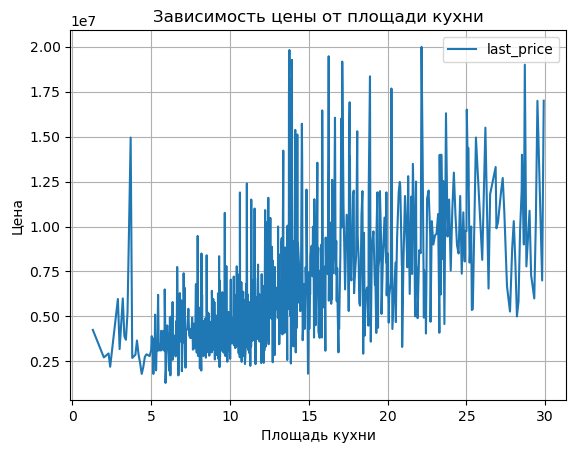

In [425]:
data_kitchen_area.plot(title='Зависимость цены от площади кухни',
                       grid=True)
plt.ylabel('Цена')
plt.xlabel('Площадь кухни')
plt.show()

Вывод: опять много выбросов, коэфицент Пирсона стал ещё меньше. Но в этот раз можно заметить, что угол наклона графика меньше, а значит увеличение площади кухни не так резко влияет на цену квартиры

In [426]:
data['rooms'].corr(data['last_price'])

0.46571216585654285

In [427]:
data_rooms = data.pivot_table(index = 'rooms', values='last_price', aggfunc='median')
data_rooms

,last_price
rooms,
0,2700000.0
1,3600000.0
2,4700000.0
3,5950000.0
4,7620000.0
5,9600000.0
6,9850000.0


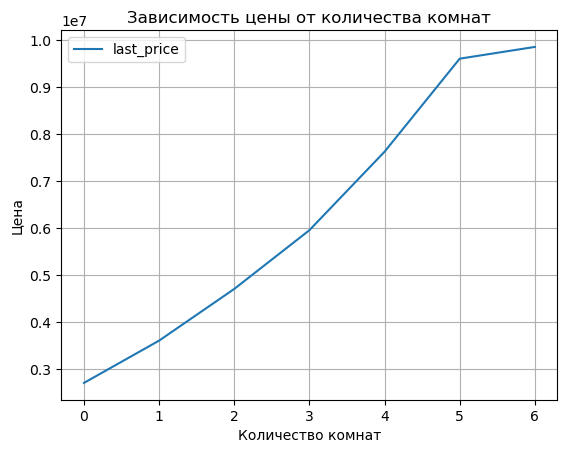

In [428]:
data_rooms.plot(title='Зависимость цены от количества комнат', grid=True)
plt.ylabel('Цена')
plt.xlabel('Количество комнат')
plt.show()

Вывод: если судить по медиане цен в зависимости от количества комнат, то цена растёт с увеличением комнат. Но коэффициент 0,43 говорит о том, что много отклонений. Построим диаграмму рассеяния

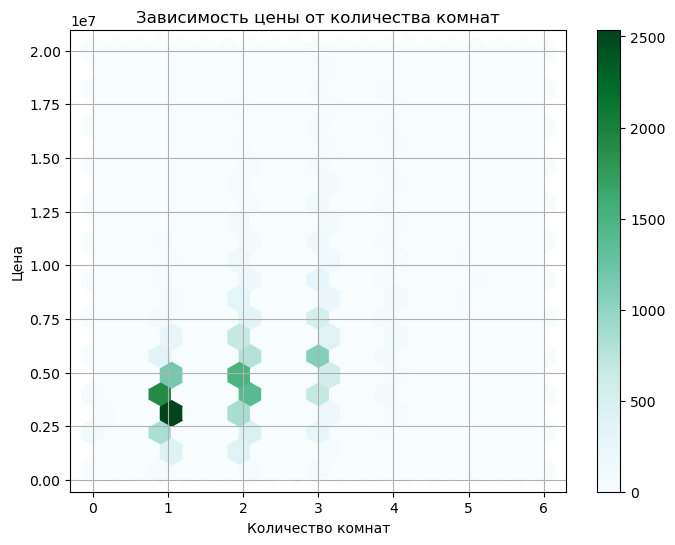

In [429]:
data.plot(x='rooms',
          y='last_price',
          kind='hexbin',
          gridsize=20,
          title='Зависимость цены от количества комнат',
          figsize=(8, 6),
          sharex=False,
          grid=True)
plt.ylabel('Цена')
plt.xlabel('Количество комнат')
plt.show()

Самые яркие точки можно соединить прямой (цена для однокомнатных 2500000, для двухкомнатных около 5000000, для трёхкомнатных чуть больше 5000000), но для каждой категории видны выбросы по цене.

In [430]:
data_floor_category = data.pivot_table(index = 'floor_category', values='last_price', aggfunc='median').sort_values(by='last_price')
data_floor_category

,last_price
floor_category,
первый,3850000.0
последний,4100000.0
другой,4650000.0


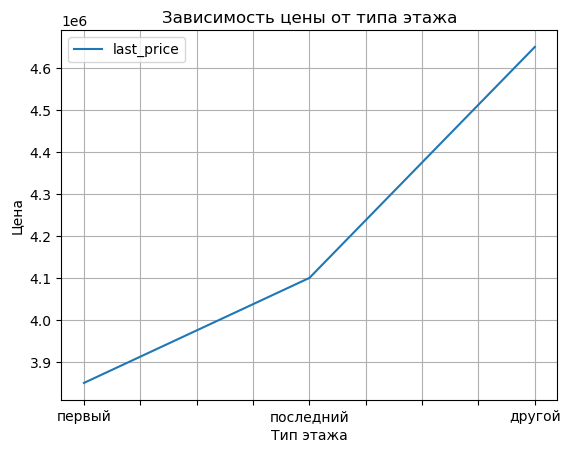

In [431]:
data_floor_category.plot(title='Зависимость цены от типа этажа',
                         grid=True)
plt.ylabel('Цена')
plt.xlabel('Тип этажа')
plt.show()

Вывод: цена растёт от квартир на первом этаже, дороже квартиры на последнем этаже, самые дорогие квартиры, расположенные на других этажах

In [432]:
data_first_day_weekday = data.pivot_table(index = 'first_day_weekday', values='last_price', aggfunc='median')
data_first_day_weekday

,last_price
first_day_weekday,
0,4500000.0
1,4550000.0
2,4530000.0
3,4500000.0
4,4400000.0
5,4450000.0
6,4450000.0


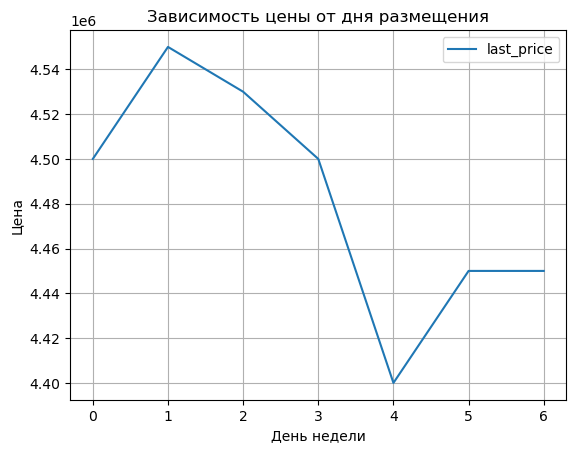

In [433]:
data_first_day_weekday.plot(title='Зависимость цены от дня размещения',
                            grid=True)
plt.ylabel('Цена')
plt.xlabel('День недели')
plt.show()

Видим, что самые дорогие квартиры, размещённые на продажу в начале недели, затем резкий спад и небольшой подъём в субботу

In [434]:
data_first_day_month = data.pivot_table(index = 'first_day_month', values='last_price', aggfunc='median')
data_first_day_month

,last_price
first_day_month,
1,4490000.0
2,4500000.0
3,4500000.0
4,4650000.0
5,4400000.0
6,4250000.0
7,4400000.0
8,4490000.0
9,4585000.0


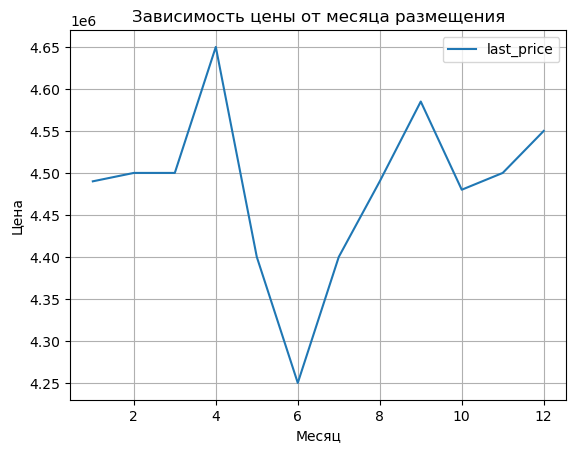

In [435]:
data_first_day_month.plot(title='Зависимость цены от месяца размещения',
                          grid=True)
plt.ylabel('Цена')
plt.xlabel('Месяц')
plt.show()

Вывод: Наблюдается резкий спад цены с мая по август. 

In [436]:
data_first_day_year = data.pivot_table(index = 'first_day_year', values='last_price', aggfunc='median')
data_first_day_year

,last_price
first_day_year,
2014,6125625.0
2015,5000000.0
2016,4370000.0
2017,4350000.0
2018,4478650.0
2019,4900000.0


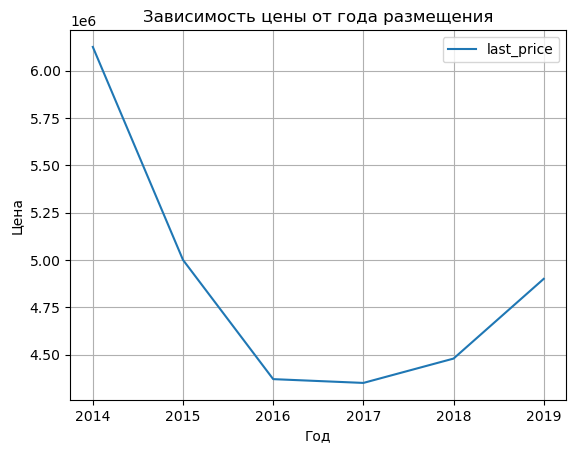

In [437]:
data_first_day_year.plot(title='Зависимость цены от года размещения',
                         grid=True)
plt.ylabel('Цена')
plt.xlabel('Год')
plt.show()

Вывод: цена падала с 2014 по 2016 года, а с 2017 начала медленно расти

### Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Населённые пункты с самой высокой и низкой стоимостью квадратного метра

In [438]:
locality_mean_price = data.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count', 'mean'])
locality_mean_price.columns = ['count', 'mean_price_per_meter']
top10_mean = locality_mean_price.sort_values(by='count', ascending=False).head(10)
top10_mean


,count,mean_price_per_meter
locality_name,,
Санкт-Петербург,14162,108380.215270
поселок Мурино,522,85827.341228
поселок Шушары,424,78833.114751
Всеволожск,381,67020.321572
Пушкин,344,101551.513020
Колпино,328,75179.651864
поселок Парголово,305,90189.447302
Гатчина,295,68693.807694
деревня Кудрово,291,92839.924793


Максимальная стоимость за один квадратный метр:

In [439]:
top10_mean.loc[top10_mean['mean_price_per_meter'] == top10_mean['mean_price_per_meter'].max()]

,count,mean_price_per_meter
locality_name,,
Санкт-Петербург,14162,108380.21527


Минимальная стоимость за один квадратный метр:

In [440]:
top10_mean.loc[top10_mean['mean_price_per_meter'] == top10_mean['mean_price_per_meter'].min()]

,count,mean_price_per_meter
locality_name,,
Выборг,231,57871.413547


### Средние цены квартир при удалении от Санкт-Петербурга


In [441]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,total_area_category,price_per_meter,first_day_weekday,first_day_month,first_day_year,floor_category,cityCenters_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.7,16,51.0,8,False,...,2.0,755.0,NaN,A,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.6,1,False,...,0.0,NaN,81.0,D,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.3,4,False,...,2.0,574.0,558.0,C,92785.714286,3,8,2015,другой,14.0
3,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.4,5,False,...,NaN,NaN,55.0,D,95065.789474,0,9,2018,другой,NaN
4,6,3700000.0,37.30,2017-11-02,1,NaN,26,10.6,6,False,...,0.0,NaN,155.0,D,99195.710456,3,11,2017,другой,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21626,9,9700000.0,133.81,2017-03-21,3,3.7,5,73.3,3,False,...,3.0,381.0,NaN,A,72490.845228,1,3,2017,другой,4.0
21627,14,3100000.0,59.00,2018-01-15,3,NaN,5,38.0,4,False,...,NaN,NaN,45.0,C,52542.372881,0,1,2018,другой,NaN
21628,18,2500000.0,56.70,2018-02-11,2,NaN,3,29.7,1,False,...,NaN,NaN,NaN,C,44091.710758,6,2,2018,первый,NaN
21629,13,11475000.0,76.75,2017-03-28,2,3.0,17,30.5,12,False,...,3.0,196.0,602.0,B,149511.400651,1,3,2017,другой,10.0


In [442]:
data_st_petersburg = data.query('locality_name == "Санкт-Петербург"')
data_st_petersburg_km = data_st_petersburg.pivot_table(index='cityCenters_nearest_km', values='last_price')
data_st_petersburg_km

,last_price
cityCenters_nearest_km,
0.0,8.798000e+06
1.0,9.898074e+06
2.0,9.195564e+06
3.0,8.379947e+06
4.0,8.782412e+06
5.0,8.886123e+06
6.0,8.226311e+06
7.0,7.664815e+06
8.0,7.543385e+06


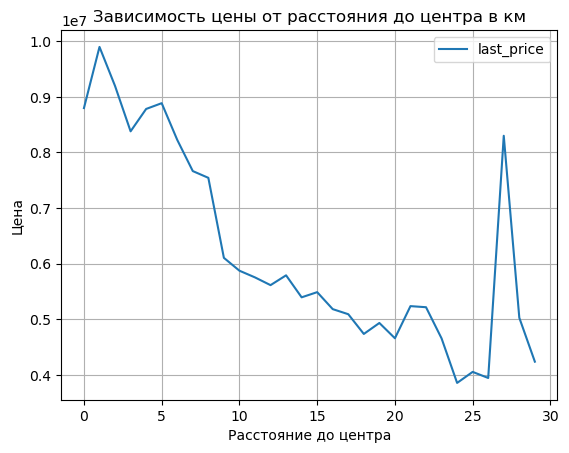

In [443]:
data_st_petersburg_km.plot(title='Зависимость цены от расстояния до центра в км',
                           grid=True)
plt.ylabel('Цена')
plt.xlabel('Расстояние до центра')
plt.show()

Цена падает с увеличением расстояния до центра города. Зона центра заканчивается на десятом километре, т.к угол наклона сильно меняется и цена перестаёт так резко падать. 
Пик на 27 км стал выше, возможно это загородное жильё премиум-класса.

### Общий вывод

В полученных днных есть пропуски. Они могли появиться в следствие того, что некоторые параметры продавцы не указали в объявлении, а некоторые пропуски могут быть связаны с технической ошибкой при выгрузке данных ( расстояния до аэропортов, парков, центров и водоёмов)

В представленном списке в основном квартиры:
- имеют стоимость 3-6 миллионов (медиана 4,5)
- имеют общую площадь 40-60м2 (медиана 50м2)
- 1,2,3-комнатные (медиана 2)
- имеют потолок 2,5-2,7м (медиана 2,6м)
- находятся в 5-16-этажных домах (медиана 9)
- имеют жилую площадь 20-40м2 (медиана 30м2)
- находятся на 2-8 этаже (медиана 4)
- имеют кухню площадью 7-11м2 (медиана 9м2)
- имеют 1 балкон или не имеют вообще
- находятся в 19-39 км от ближайшего аэропорта (медиана 30 км)
- находятся в 10-16 км от центра города (медиана 14 км)
- имеют 0-1 парк в радиусе 3000м
- находятся в 400-600м от ближайшего парка (медиана 500м)
- имеют в радиусе 3000м 0-1 водоём
- находятся в продаже 40-200 дней (медиана 90)

Исследование зависимостей:
- Самые быстрые продажи - 50 дней, за это время было продано больше 5000 квартир. С увеличением времени размещения объявления количество продаж уменьшается. Также есть очень долгие продажи - 1300 дней
- Нагляднее всего прослеживается зависимость цены от общей площади квартиры (чем больше площадь, тем выше цена). Жилая площадь и площадь кухни тоже влияют на цену, но меньше
- Чем больше комнат в квартире, тем она дороже
- У квартир, размещённых на продажу в начале недели, цена выше
- Цена на квартиры падала с 2014 по 2016 год, а с 2017 начала медленно расти
- Чаще всего квартиры продавали в Санкт-Петербурге, поселке Мурино, Всеволодске, поселке Шушары, Гатчине, деревне Кудрово, поселке Парголово, Выборге, Пушкине, Кудрово. Причём в Санкт-Петербурге самая большая цена за один квадратный метр, а в Выборге самая маленькая
- В Санкт-Петербурге цены на квартиры падают с удалением от центра города